# **MNIST Dataset 불러오기**

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import PIL
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


batch_size = 32

#torchvision 패키지에 저장되어 있는 MNIST 데이터 셋을 불러옴
train_data = torchvision.datasets.MNIST(root = './data',
                            train=True,
                            download=True,
                            transform=transforms.ToTensor())
test_data = torchvision.datasets.MNIST(root = './data',
                            train=False,
                            download=True,
                            transform=transforms.ToTensor())

#DataLoader 함수로 전체 데이터를 배치사이즈 만큼 묶어줌
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                           batch_size = batch_size, shuffle = True)

100%|██████████| 9912422/9912422 [00:00<00:00, 90887791.28it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 98967070.12it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26254636.76it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12820005.90it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

600
100


# **MNIST Dataset 이미지 출력**

torch.Size([1, 28, 28])
5
<class 'torch.Tensor'>


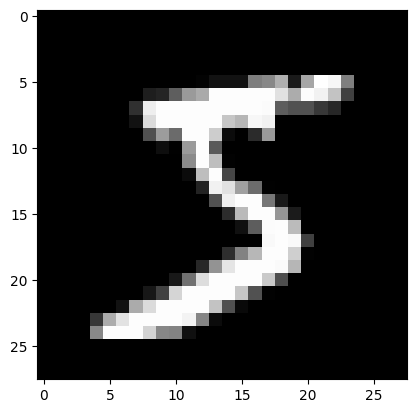

In [ ]:
from matplotlib import pyplot as plt

#데이터 세트의 첫번째 인덱스 할당
image ,label = train_data[0]

print(image.shape)
print(label)
print(type(image))

plt.imshow(image.squeeze(0).numpy(), cmap = 'gray')

# **MLP 네트워크 구성하기**

In [ ]:
class MLP(nn.Module):
    def __init__(self):
      super(MLP, self).__init__()

      self.layer1 = nn.Linear(28*28,512,bias=False)
      self.layer2 = nn.Linear(512,256,bias=False)
      self.layer3 = nn.Linear(256,10,bias=False)
      self.batch_norm1 = nn.BatchNorm1d(512)
      self.batch_norm2 = nn.BatchNorm1d(256)

    def forward(self, x):
      x = x.view(-1,28*28)

      x = self.layer1(x)
      x = self.batch_norm1(x)
      x = F.relu(x)
      x = self.layer2(x)
      x = self.batch_norm2(x)
      x = F.relu(x)
      x = self.layer3(x)
      x = F.log_softmax(x,dim=1)

      return x

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = MLP().to(device)
print(net)

# **Optimizer와 손실 함수 정의하기**

In [ ]:
optimizer = torch.optim.Adam(net.parameters(),lr =0.01)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True, min_lr=0)
epoches =10

# **학습 진행하기**

In [ ]:
loss_hist, acc_hist = [], []

net.train()

for epoch in range(epoches):
  running_loss = 0.0
  correct = 0
  for data in train_loader:
    batch, labels = data
    batch, labels = batch.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = net(batch)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # compute training statistics
    _, predicted = torch.max(outputs, 1)
    correct += (predicted == labels).sum().item()
    running_loss += loss.item()

  avg_loss = running_loss / len(train_data)
  avg_acc = correct / len(train_data)
  loss_hist.append(avg_loss)
  acc_hist.append(avg_acc)
  scheduler.step(avg_loss)
  print('[epoch %d] Train>>> loss: %.6f accuracy: %.4f ' % (epoch + 1, avg_loss, avg_acc))

# **학습 과정 시각화**

In [ ]:
legend = ['Train']
plt.plot(loss_hist)
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(legend, loc='upper left')
plt.show()

legend = ['Train']
plt.plot(acc_hist)
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(legend, loc='upper left')
plt.show()

# **Test set에서 결과 예측하고 성능 테스트하기**

In [ ]:
correct = 0
net.eval()
with torch.no_grad():
    for data in test_loader:
        batch, labels = data
        batch, labels = batch.to(device), labels.to(device)
        outputs = net(batch)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()

print('Accuracy on the 10000 test images: %.2f %%' % (100 * correct / len(test_data)))

# **CIFAR-10 Dataset 불러오기**

In [ ]:
#데이터 변형 옵션을 위해 미리 설정값을 셋업해둠
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

#torchvision 패키지로부터 미리 설정해둔 값으로 변경해서 받아옴
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=4, shuffle=True)


testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=4, shuffle=False)

100%|██████████| 170498071/170498071 [00:01<00:00, 92637548.22it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# **CIFAR-10 Dataset 이미지 출력**



9
torch.Size([3, 32, 32])
(32, 32, 3)


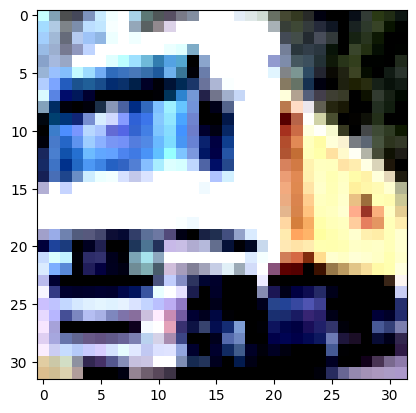

In [ ]:
import numpy as np

#데이터 세트의 첫번째 인덱스 할당
image ,label = trainset[1]

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()

    print(label)
    print(image.shape)
    print(np.transpose(npimg,(1,2,0)).shape)

    plt.imshow(np.transpose(npimg, (1, 2, 0)))

imshow(image)

# **CIFAR-10 Dataset 클래스 별 이미지 출력**

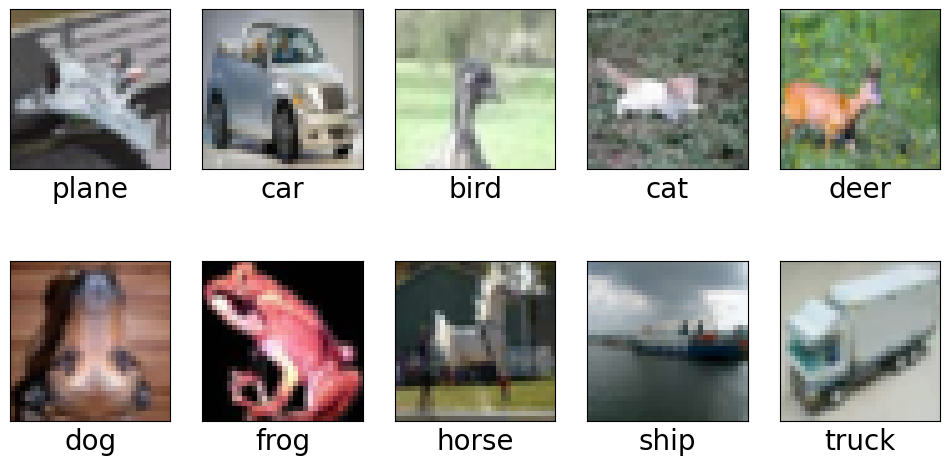

In [ ]:
#클래스 별 이름 붙이기
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# 각 클래스의 데이터를 리스트로 만들기
sample_images = [trainset.data[np.asarray(trainset.targets) == label][7] for label in range(10)]


# 이미지를 시각화하기
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
i = 0
for row in axes:
  for axis in row:
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xlabel(classes[i], fontsize=20)
    axis.imshow(sample_images[i])
    i += 1